## Import lib

In [ ]:
!pip install -q torchinfo

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# run 11111111
import os
import tarfile
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchinfo import summary

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/MyDrive/3_XuLyAnh_Flowers'

In [ ]:
IMG_SIZE      = 224
BATCH_SIZE    = 8
RANDOM_SEED   = 42

## Data

In [ ]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [ ]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [ ]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [ ]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]

In [ ]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

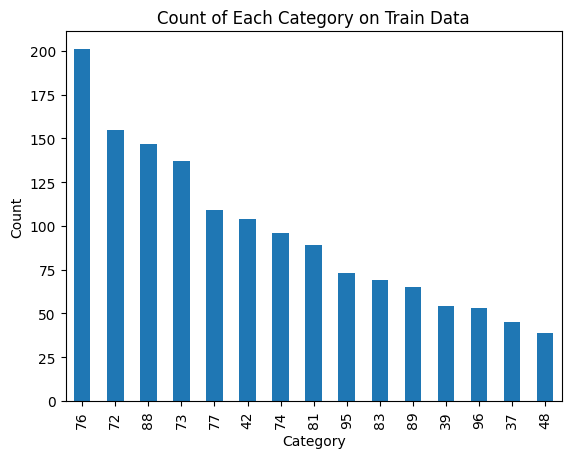

In [ ]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

### Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 50,
    shear_range = 0.2,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.5, 1.5],
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = RANDOM_SEED
)

Found 1436 validated image filenames belonging to 15 classes.
Found 360 validated image filenames belonging to 15 classes.


In [ ]:
train_generator.samples

1436

Ví dụ về hình ảnh từ train_generator


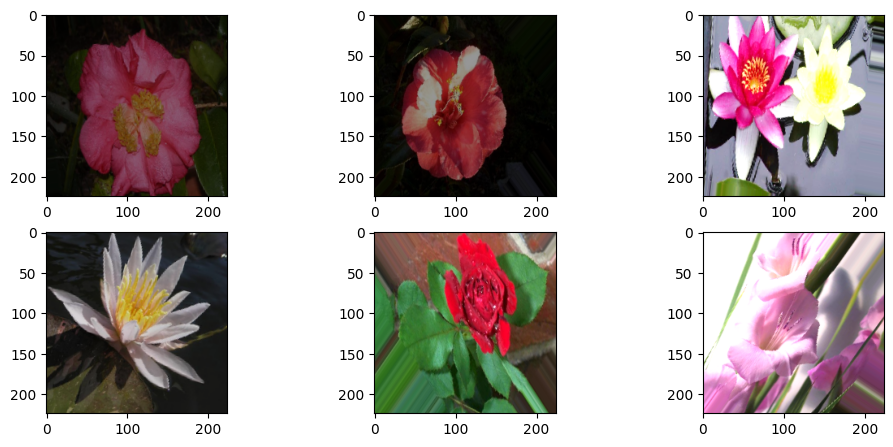

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

Ví dụ về hình ảnh từ test_generator


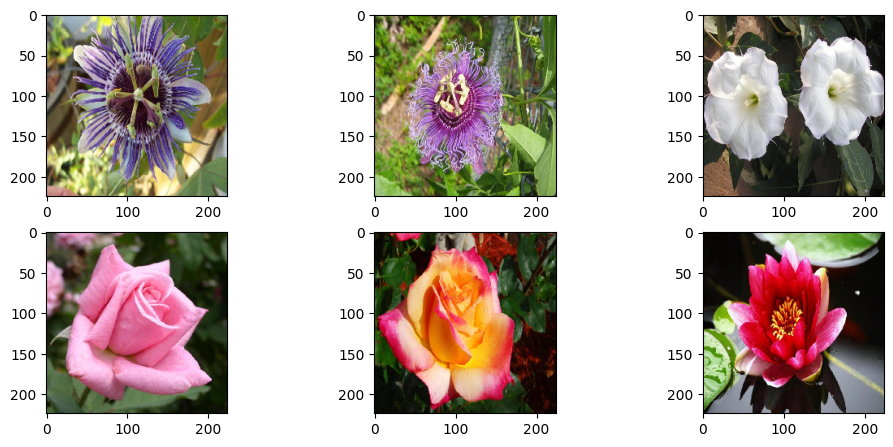

In [ ]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## Main function

In [ ]:
# def main():
#     # Loading data
#     transform = ToTensor()

#     train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
#     test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

#     train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
#     test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

#     # Defining model and training options
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
#     model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
#     N_EPOCHS = 5
#     LR = 0.005

#     # Training loop
#     optimizer = Adam(model.parameters(), lr=LR)
#     criterion = CrossEntropyLoss()
#     for epoch in trange(N_EPOCHS, desc="Training"):
#         train_loss = 0.0
#         for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
#             x, y = batch
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat, y)

#             train_loss += loss.detach().cpu().item() / len(train_loader)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

#     # Test loop
#     with torch.no_grad():
#         correct, total = 0, 0
#         test_loss = 0.0
#         for batch in tqdm(test_loader, desc="Testing"):
#             x, y = batch
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat, y)
#             test_loss += loss.detach().cpu().item() / len(test_loader)

#             correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
#             total += len(x)
#         print(f"Test loss: {test_loss:.2f}")
#         print(f"Test accuracy: {correct / total * 100:.2f}%")

## Model ViT

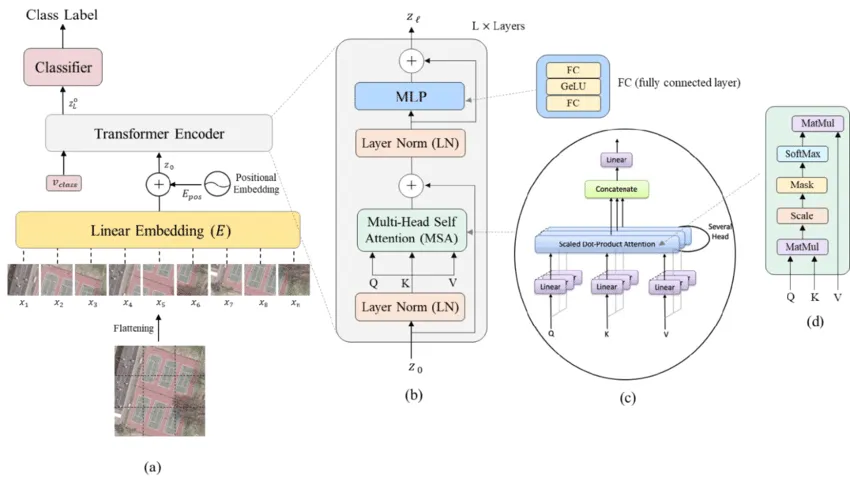

Hình (a):
- ảnh được chia thành các phần nhỏ có kích thước bằng nhau
- trải qua quá trình embedding tuyến tính trở thành các vector một chiều.
- đánh thêm positional embbedding cho mỗi vector (giúp giữ được vị trí gốc)
- sau đó, các mã thông báo này được chuyển cùng với mã thông báo phân loại đặc biệt đến các khối encoder transformer, mỗi khối bao gồm: Chuẩn hóa lớp (LN), theo sau là Tự chú ý nhiều đầu (MSA) và kết nối còn lại. Sau đó là LN thứ hai, Perceptron nhiều lớp (MLP) và một lần nữa là kết nối còn lại. Các khối này được kết nối ngược lại.

### Step 1: Patchifying and the linear mapping

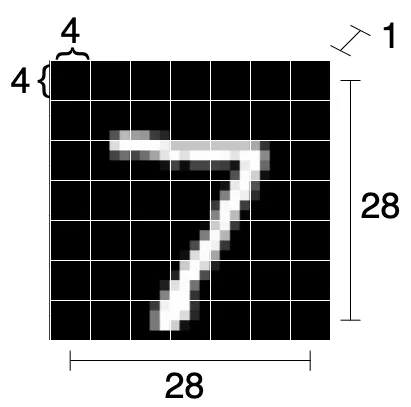

In [ ]:
# run 2222222
def patchify(images, n_patches):
    n, c, h, w = images.shape
    # print("n, c, h, w", n, c, h, w)
    assert h == w, "Patchify method is implemented for square images only"
    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches
    # print("Patches shape:", patches.shape)
    # print("Positional embeddings shape:", model.positional_embeddings.shape)
    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                # print(patch.shape)
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [ ]:
# if __name__ == '__main__':
#   # Current model
#   model = MyViT(
#     chw=(1, 28, 28),
#     n_patches=7
#   )

#   x = torch.randn(7, 1, 28, 28) # Dummy images
#   print(model(x).shape) # torch.Size([7, 49, 16])

Create a Linear Layer

### Step 2: Adding the classification token

### Step 3: Positional encoding

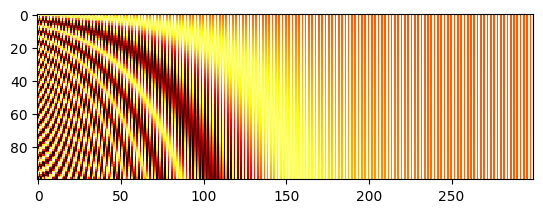

In [ ]:
# run 3333333
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

### Step 4: The encoder block (Part 1/2)

- Layer Normalization là một khối phổ biến, với một đầu vào được cung cấp, sẽ trừ giá trị trung bình của nó và chia cho độ lệch chuẩn.
- Multi-head Self Attention
- Residual connection

In [ ]:
# run 44444444
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [ ]:
# class MyViTBlock(nn.Module):
#     def __init__(self, hidden_d, n_heads, mlp_ratio=4):
#         super(MyViTBlock, self).__init__()
#         self.hidden_d = hidden_d
#         self.n_heads = n_heads

#         self.norm1 = nn.LayerNorm(hidden_d)
#         self.mhsa = MyMSA(hidden_d, n_heads)

#     def forward(self, x):
#         out = x + self.mhsa(self.norm1(x))
#         return out

### Step 5: The encoder block (Part 2/2)

In [ ]:
# run 55555555
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [ ]:
# if __name__ == '__main__':
#   model = MyViTBlock(hidden_d=8, n_heads=2)

#   x = torch.randn(7, 50, 8)  # Dummy sequences
#   print(model(x).shape)      # torch.Size([7, 50, 8])

### Step 6: Classification MLP

In [ ]:
# run 66666666
class MyViT(nn.Module):
    def __init__(self, chw, embedding_dims=768, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        print("chw", chw)
        print("n_patches", n_patches)
        print("n_blocks", n_blocks)
        print("hidden_d", hidden_d)
        print("n_heads", n_heads)
        print("out_d", out_d)
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # # 0) Conv2D
        # self.conv_layer = nn.Conv2d(in_channels = chw[0], out_channels = embedding_dims, kernel_size = n_patches, stride = n_patches//2)
        # self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

        # 1) Linear mapper
        # print(chw[0], self.patch_size[0], self.patch_size[1])
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        # self.input_d = int(embedding_dims)
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape                                                           # 7, 1, 28, 28
        # print(images.shape)
        # images = self.conv_layer(images)
        # print(images.shape)
        # patches = self.flatten_layer(images)
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)    # 7, 49, 16
        # print(patches.shape)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)                                                # 7, 49, 8

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)              # 7, 50, 8

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)                           # 7, 50, 8

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)                                                                # 7, 50, 8

        # Getting the classification token only
        out = out[:, 0]                                                                     # 7, 1, 8

        return self.mlp(out) # Map to output dimension, output category distribution        # 7, 1, 10

## Results

### Nháp

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [ ]:
# model = MyViT((1, 28, 28), n_patches=7, n_blocks=4, hidden_d=32, n_heads=8, out_d=10).to(device)

In [ ]:
# main()

In [ ]:
# # Loading data
# transform = ToTensor()

# train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
# test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_set, shuffle=True, batch_size=512)
# test_loader = DataLoader(test_set, shuffle=False, batch_size=512)

In [ ]:
# print(train_set)

### Các tham số của model:
- n_patches=7: input đang là 28x28 => chia ra thành 7x7 tức là mỗi sub_image có kích thước 4x4
- n_blocks=2: có 2 khối encoder
- hidden_d=8: mỗi sub_image có kích thước 1x4x4 => vector 1D có chiều dài là 8
- n_heads=2: hidden_d = 8 chia hết cho 2 => input của MSA => tăng hidden_d thì nên tăng thêm n_heads
- out_d=10: số nhãn của tập dữ liệu


In [ ]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
# 250/10=25  => n_patches = 25, size_sub_image = 3*10*10 => hidden_d = 1024 => n_heads=16, out_d = 15
# 250/25=10 => n_patches = 10, size_sub_image = 3*25*25 => hidden_d = 1024 => n_heads=16, out_d = 15
model = MyViT((3, 224, 224), embedding_dims=768, n_patches=16, n_blocks=12, hidden_d=768, n_heads=12, out_d=15).to(device)
N_EPOCHS = 10
LR = 0.005

Using device:  cpu 
chw (3, 224, 224)
n_patches 16
n_blocks 12
hidden_d 768
n_heads 12
out_d 15


In [ ]:
summary(model=model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MyViT (MyViT)                                 [8, 3, 224, 224]     [8, 15]              768                  True
├─Linear (linear_mapper)                      [8, 256, 588]        [8, 256, 768]        452,352              True
├─ModuleList (blocks)                         --                   --                   --                   True
│    └─MyViTBlock (0)                         [8, 257, 768]        [8, 257, 768]        --                   True
│    │    └─LayerNorm (norm1)                 [8, 257, 768]        [8, 257, 768]        1,536                True
│    │    └─MyMSA (mhsa)                      [8, 257, 768]        [8, 257, 768]        149,760              True
│    │    └─LayerNorm (norm2)                 [8, 257, 768]        [8, 257, 768]        1,536                True
│    │    └─Sequential (mlp)                  [8, 257, 768]        [8, 257, 768]   

In [ ]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss().to(device)
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    total_batches = len(train_generator)
    print(total_batches)
    processed_batches = 0
    # change here
    for batch in tqdm(train_generator, desc=f"Epoch {epoch + 1} in training", leave=False, dynamic_ncols=True):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(device).permute(0, 3, 1, 2)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        # print(y)
        # Sử dụng argmax để lấy chỉ số của giá trị lớn nhất trong mỗi hàng
        y = torch.argmax(y, dim=1)
        # print(y)
        # print("\nx.shape", x.shape)
        # x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_generator)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        processed_batches += 1
        if processed_batches>total_batches:
          break

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")


Training:   0%|          | 0/10 [00:00<?, ?it/s]

180



Epoch 1 in training:   0%|          | 0/180 [00:00<?, ?it/s]

n, c, h, w 8 3 224 224

Patches shape: torch.Size([8, 256, 588])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])


Epoch 1 in training:   1%|          | 1/180 [00:05<16:18,  5.47s/it]

n, c, h, w 8 3 224 224

Patches shape: torch.Size([8, 256, 588])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])


Epoch 1 in training:   1%|          | 2/180 [00:09<13:39,  4.60s/it]

n, c, h, w 8 3 224 224

Patches shape: torch.Size([8, 256, 588])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])
torch.Size([3, 14, 14])


Training:   0%|          | 0/10 [02:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    total_batches = len(test_generator)
    print(total_batches)
    processed_batches = 0
    for batch in tqdm(test_generator, desc="Testing"):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(device).permute(0, 3, 1, 2)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        # x, y = x.to(device), y.to(device)
        y = torch.argmax(y, dim=1)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_generator)
        # print(torch.argmax(y_hat, dim=1))
        # print(y)
        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        processed_batches += 1
        if processed_batches>total_batches:
          break
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

## SaveModel

In [ ]:
torch.save(model.state_dict(), 'ViT_p50_d1024_flower.pth')

In [ ]:
model.load_state_dict(torch.load('ViT_p50_d1024_flower.pth'))